# Concise Implementation of Multi-GPU Computation

:label:`chapter_multi_gpu_gluon`


In Gluon, we can conveniently use data parallelism to perform multi-GPU
computation. For example, we do not need to implement the helper function to
synchronize data among multiple GPUs, as described in
:numref:`chapter_multi_gpu`, ourselves.

First, import the required packages or modules for the experiment in this section. Running the programs in this section requires at least two GPUs.

In [1]:
import d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

## Initialize Model Parameters on Multiple GPUs

In this section, we use ResNet-18 as a sample model. Since the input images in
this section are original size (not enlarged), the model construction here is
different from the ResNet-18 structure described in :numref:`chapter_resnet`. This
model uses a smaller convolution kernel, stride, and padding at the beginning
and removes the maximum pooling layer.

In [2]:
# Save to the d2l package.
def resnet18(num_classes):
    """A slightly modified ResNet-18 model"""
    def resnet_block(num_channels, num_residuals, first_block=False):
        blk = nn.Sequential()
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.add(d2l.Residual(
                    num_channels, use_1x1conv=True, strides=2))
            else:
                blk.add(d2l.Residual(num_channels))
        return blk

    net = nn.Sequential()
    # This model uses a smaller convolution kernel, stride, and padding and
    # removes the maximum pooling layer
    net.add(nn.Conv2D(64, kernel_size=3, strides=1, padding=1),
            nn.BatchNorm(), nn.Activation('relu'))
    net.add(resnet_block(64, 2, first_block=True),
            resnet_block(128, 2),
            resnet_block(256, 2),
            resnet_block(512, 2))
    net.add(nn.GlobalAvgPool2D(), nn.Dense(num_classes))
    return net

net = resnet18(10)

Previously, we discussed how to use the `initialize` function's `ctx` parameter to initialize model parameters on a CPU or a single GPU. In fact, `ctx` can accept a range of CPUs and GPUs so as to copy initialized model parameters to all CPUs and GPUs in `ctx`.

In [3]:
ctx = d2l.try_all_gpus()
net.initialize(init=init.Normal(sigma=0.01), ctx=ctx)

Gluon provides the `split_and_load` function implemented in the previous section. It can divide a mini-batch of data instances and copy them to each CPU or GPU. Then, the model computation for the data input to each CPU or GPU occurs on that same CPU or GPU.

In [4]:
x = np.random.uniform(size=(4, 1, 28, 28))
gpu_x = gluon.utils.split_and_load(x, ctx)
net(gpu_x[0]), net(gpu_x[1])

(array([[ 9.4988764e-07,  4.0808845e-06, -5.1063816e-06, -4.9375967e-06,
          1.1718329e-06, -5.6178824e-06, -4.8232919e-06,  1.9737163e-06,
         -7.3709026e-07,  2.2256274e-06],
        [ 7.7096996e-07,  4.2829342e-06, -6.1890505e-06, -5.4664861e-06,
          1.2786281e-06, -5.2085825e-06, -4.6386904e-06,  2.0427817e-06,
         -1.0129007e-06,  2.0370280e-06]], ctx=gpu(0)),
 array([[ 2.4921033e-07,  3.8222056e-06, -5.5915402e-06, -5.4971724e-06,
          1.4587372e-06, -4.5317338e-06, -4.8936981e-06,  2.3227499e-06,
         -3.8662023e-07,  1.8324375e-06],
        [-8.7117598e-08,  3.6717909e-06, -5.0221552e-06, -5.0705357e-06,
          2.1382066e-06, -4.9615883e-06, -4.7389462e-06,  2.3168993e-06,
         -4.3993109e-07,  2.1564051e-06]], ctx=gpu(1)))

Now we can access the initialized model parameter values through `data`. It should be noted that `weight.data()` will return the parameter values on the CPU by default. Since we specified 2 GPUs to initialize the model parameters, we need to specify the GPU to access parameter values. As we can see, the same parameters have the same values on different GPUs.

In [5]:
weight = net[0].params.get('weight')

try:
    weight.data()
except RuntimeError:
    print('not initialized on cpu')
weight.data(ctx[0])[0], weight.data(ctx[1])[0]

not initialized on cpu


(array([[[ 0.02212206,  0.00774004,  0.0104344 ],
         [ 0.01183925,  0.01891711, -0.01234741],
         [-0.01771029, -0.00451384,  0.00579384]]], ctx=gpu(0)),
 array([[[ 0.02212206,  0.00774004,  0.0104344 ],
         [ 0.01183925,  0.01891711, -0.01234741],
         [-0.01771029, -0.00451384,  0.00579384]]], ctx=gpu(1)))

Remember we define the `evaluate_accuracy_gpu` in :numref:`chapter_lenet` to support evaluating on a single GPU, now we refine this implementation to support multiple devices.

In [6]:
# Save to the d2l package.
def evaluate_accuracy_gpus(net, data_iter, split_f = d2l.split_batch):
    # Query the list of devices.
    ctx_list = list(net.collect_params().values())[0].list_ctx()
    metric = d2l.Accumulator(2)  # num_corrected_examples, num_examples
    for features, labels in data_iter:
        Xs, ys = split_f(features, labels, ctx_list)
        pys = [net(X) for X in Xs]  # run in parallel
        metric.add(sum(float(d2l.accuracy(py, y)) for py, y in zip(pys, ys)), 
                   labels.size)
    return metric[0]/metric[1]

## Multi-GPU Model Training

When we use multiple GPUs to train the model, the `Trainer` instance will automatically perform data parallelism, such as dividing mini-batches of data instances and copying them to individual GPUs and summing the gradients of each GPU and broadcasting the result to all GPUs. In this way, we can easily implement the training function.

In [7]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    ctx_list = [d2l.try_gpu(i) for i in range(num_gpus)]
    net.initialize(init=init.Normal(sigma=0.01),
                   ctx=ctx_list, force_reinit=True)
    trainer = gluon.Trainer(
        net.collect_params(), 'sgd', {'learning_rate': lr})
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 2
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        timer.start()
        for features, labels in train_iter:
            Xs, ys = d2l.split_batch(features, labels, ctx_list)
            with autograd.record():
                ls = [loss(net(X), y) for X, y in zip(Xs, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
        npx.waitall()
        timer.stop()
        animator.add(epoch+1, (evaluate_accuracy_gpus(net, test_iter),))
    print('test acc: %.2f, %.1f sec/epoch on %s' % (
        animator.Y[0][-1], timer.avg(), ctx_list))

First, use a single GPU for training.

test acc: 0.91, 13.6 sec/epoch on [gpu(0)]


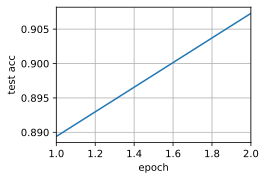

In [8]:
train(num_gpus=1, batch_size=256, lr=0.1)

Then we try to use 2 GPUs for training. Compared with the LeNet used in the previous section, ResNet-18 computing is more complicated and the communication time is shorter compared to the calculation time, so parallel computing in ResNet-18 better improves performance.

test acc: 0.86, 7.0 sec/epoch on [gpu(0), gpu(1)]


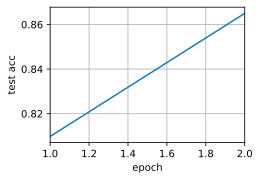

In [9]:
train(num_gpus=2, batch_size=512, lr=0.2)

## Summary

* In Gluon, we can conveniently perform multi-GPU computations, such as initializing model parameters and training models on multiple GPUs.

## Exercises

* This section uses ResNet-18. Try different epochs, batch sizes, and learning rates. Use more GPUs for computation if conditions permit.
* Sometimes, different devices provide different computing power. Some can use CPUs and GPUs at the same time, or GPUs of different models. How should we divide mini-batches among different CPUs or GPUs?

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2384)

![](../img/qr_multiple-gpus-gluon.svg)